$$\newcommand{\bra}[1]{\left|{#1}\right\rangle}$$ $$\newcommand{\ket}[1]{\left\langle{#1}\right|}$$ $$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
# Exact Diagonalization - Evolution and Entanglement of a System of N Spins

## Introduction

The following code computes the time evolution of a system of N spins to see how this evolution affects entanglement. More precisely, it take an initially unentangled state, $\bra{\Psi}$, and evolves it over time, computing the Von Neumann entropy at each timestep. The Von Neumann entropy of a pure multipartite system $\bra{\Psi_{AB}}$ is defined by,

\begin{align*} S = \sum_n \rho_n \log_2(\rho_n) \label{eq1} &&(1) \end{align*}

where $\{\rho_n\}$ are the eigenvalues of $\hat{\rho}_{AB} = \bra{\Psi_{AB}}\ket{\Psi_{AB}}$. The Von Neumann entropy of a reduced density matrix,

$$ \rho_A = \text{Tr}({\bra{\Psi_{AB}}\ket{\Psi_{AB}}}) = \sum_j \ket{j_B}({\bra{\Psi_{AB}}\ket{\Psi_{AB}}})\bra{j_B} = \sum_j (\hat{\rho}_A)_{mn} $$

is a measure of the entanglement of the system. If a system is separable, it is not entangled and therefore it's Von Neumann entropy is zero.

The system evolves according to: 

$$ \bra{\Psi(t)} = e^{-iHt}\bra{\Psi(0)}$$

where $H$ is the the Hamiltonian:

\begin{align*} H=-(\cos{\theta}(\sigma_x\otimes\sigma_x)+\frac{\sin{\theta}}{2}(\sigma_z\otimes I+I\otimes\sigma_z)) + \frac{1}{2}(\sigma_x\otimes\sigma_y+\sigma_y\otimes\sigma_x) && (2) \end{align*}

where the $\sigma_i$s are the Pauli matrices and $I$ is the identity. The first term in the Hamiltonian is the Ising Model.

Computing the time evolution in the way, however, is computationally expensive, so the evolution can be approximated by equation (4), which uses sparse multiplication instead of an  exponential.

Starting in a separable state, the entanglement of the system should increase with time until the system is fully entangled, as the code below shows.

In [1]:
using Plots
using LinearAlgebra
using Arpack

## Functions

### compute_rdmA(PsiAB) 

Returns the reduced density matrix of PsiAB. It computes the reduced density matrix using equation (3), which is derived in the following way:

$$ \hat{\rho}_A = \text{Tr}({\bra{\Psi_{AB}}\ket{\Psi_{AB}}}) = \sum_j \ket{j_B}({\bra{\Psi_{AB}}\ket{\Psi_{AB}}})\bra{j_B} = \sum_j (\hat{\rho}_A)_{mn} $$
$$ (\hat{\rho}_{A})_{m,n} = \sum_j \psi_{mj} \psi^*_{nj} $$ 
\begin{align*} \hat{\rho}_A=\Psi\Psi^t && (3) \end{align*}

This function was taken from the course notes.

### compute_entropy(dm)

Computes the entropy of the density matrix dm using (1). This function was taken from the course notes.

### compute_entropyNHalf(psi)

Computes the entropy psi by taking the reduced density matrix for half the spins.

### multiplyHPsi(Psi,H2)

Uses sparse multiplication to multiply Psi by H2. The function reshapes Psi so that it can be multiplied by a 2x2 matrix (which represents the Hamiltonian) N times, instead of multipling Psi by the full Hamitonian, which is a $2^N$x$2^N$ matrix. This function was taken from the course notes.

### psiNew(Psi,H,dt)

Evolves Psi by a timestep dt. This evolution is accomplished by looking at the Schrodinger equation:

$$\frac{d\bra{\Psi(t)}}{dt} = -iH\bra{\Psi(t)}$$

and approximating the derivative by:

$$\frac{d\bra{\Psi(t)}}{dt}\approx \frac{\bra{\Psi(t+\delta t)}-\bra{\Psi(t)}}{\delta t} $$

so that $\bra{\Psi(t+\delta t)}$ is computed using

\begin{align*}\bra{\Psi(t+\delta t)}= \bra{\Psi(t)}-i\delta tH\bra{\Psi(t)}&& (4) \end{align*}

where the multiplication $H\bra{\Psi(t)}$ is carried out using the sparse multiplication function multiplyHPsi.

### buildH(theta=pi/4)

Builds the Hamiltonian for two spins. In this case, the Hamiltonain is given by equation (2).

In [2]:
function compute_rdmA(PsiAB)
    @assert ndims(PsiAB) == 2 # did we input a matrix?
    @assert size(PsiAB,1) < 2^13 # make sure the resulting matrix is not too large!
    rdm = PsiAB*PsiAB'
end

compute_rdmA (generic function with 1 method)

In [3]:
function compute_entropy(dm)
    p = eigvals(dm)
    entropy = 0.0
    #entropy = - p'*log2.(p) # problems when p[n] is of order 0 (possibly negative)
    for n in 1:size(p,1)
        if abs(p[n]) > 1e-12
            entropy = entropy - p[n]*log2(p[n])
        end
    end
    entropy
end

compute_entropy (generic function with 1 method)

In [4]:
function compute_entropyNHalf(Psi)
    
    @assert ndims(Psi) == 1 # make sure Psi is a vector
    N = floor(Int64,log2(size(Psi,1) + 1e-5))   # fincd number of spins

    Psi = Psi/sqrt(Psi'*Psi) # Normalize Psi
    
    PsiAB = reshape(Psi, (floor(Int64,2^(N/2)),floor(Int64(2^(N/2))))) # Reshape Psi so that half the spins can be
                                                                       # taken out when the reduced density matrix
                                                                       # is coputed.
        
    rdmA = compute_rdmA(PsiAB) # compute the reduced dentisty matrix
    entropy = compute_entropy(rdmA) # compute the entropy
    
    return entropy

end


compute_entropyNHalf (generic function with 1 method)

In [5]:
# function for sparse multiplication

function multiplyHPsi(Psi, H2) 
    L = length(Psi)  # Dimension of the vector space
    N = convert(Int64,log2(L))  # Number of spins
    HPsi = zeros(L)
    for n=1:N                              # This multiplies by the Hamiltonian H
        Psi = reshape(Psi,(4,2^(N-2)))
        HPsi = reshape(HPsi,(4,2^(N-2)))
        HPsi += H2*Psi                 
        Psi = reshape(Psi,(2,2^(N-1)))
        HPsi = reshape(HPsi,(2,2^(N-1)))
        Psi = permutedims(Psi,(2,1))
        HPsi = permutedims(HPsi,(2,1))
    end
    Psi = reshape(Psi,L)
    HPsi = reshape(HPsi, L)
    return HPsi
end

multiplyHPsi (generic function with 1 method)

In [6]:
function psiNew(Psi,H,dt)
    
    HPsi = multiplyHPsi(Psi,H) # Do the sparse multiplication
    
    pNew = Psi + im*dt*HPsi    # Compute Psi at the new timestep
   
    return pNew
    
end

psiNew (generic function with 1 method)

In [7]:
# Ising model
function buildH(theta=pi/4) # (critical theta=pi/4 by default)
    
    X = [0. 1; 1 0]         # Pauli x matrix
    Y = [0. -im; im 0]      # Pauli y matrix
    Z = [1. 0; 0 -1]        # Paulie z matrix
    
    E = [1. 0; 0 1]         # Identity
    
    # Take all of the vector products:
    
    XX = kron(X,X)
    XY = kron(X,Y)
    YX = kron(Y,X)
    HZ = kron(Z,E) + kron(E,Z)
    
    # Compute the Hamiltonian
    
    H2 = -(cos(theta)*XX + sin(theta)/2*HZ)+ 0.5*(XY+YX)
    
    return H2
end

buildH (generic function with 2 methods)

## Testing the code for N=6:

First check that the code works for small N. In this case test N=6. The initial state of the system is given by:

$$ \bra{\Psi} = \bra{\Psi_1} \otimes \bra{\Psi_2} \otimes \bra{\Psi_3} \otimes ... \otimes \bra{\Psi_N} $$

In [9]:
N = 6 # Number of spins

H = buildH(pi/4) # Building the Hamiltonian

# Initialize Psi for N random spins

Psi_temp = randn(2,N) + im*randn(2,N)
Psi = Psi_temp[:,1]

for i in 2:N
    Psi = kron(Psi,Psi_temp[:,i])
end

# Normalize Psi
Psi = Psi/sqrt(abs(Psi'*Psi))

# Compute how long the functions take to run:

@time multiplyHPsi(Psi,H)
@time compute_entropyNHalf(Psi)
;

  0.000018 seconds (82 allocations: 30.578 KiB)
  0.000237 seconds (29 allocations: 12.344 KiB)


It is important for $\bra{\Psi}$ to remain normalized as it evolves in time. The following cell computes the maximum dt for the norm to remain within epsilon of 1 after a time T.

In [10]:
T = 10.0 # Time to evolve
dt = 10.0 # Timestep

epsilon = 10^-2

Psi_temp = 0

while norm(Psi_temp) < (1.0-epsilon) || norm(Psi_temp) > (1.0+epsilon)
    
    Psi_temp = Psi # Make sure Psi_temp is beginning normalized
    
    dt = dt/10.0 # Next timestep
    
    for i = 1:floor(Int64,T/dt)          # Evolve Psi_temp
        Psi_temp = psiNew(Psi_temp,H,dt)
    end
    
    print("Timestep size: ",dt, ", Norm:", norm(Psi_temp), "\n") # Print the stepsize and the norm
    
end

Timestep size: 1.0, Norm:2.933110560651882e7
Timestep size: 0.1, Norm:3.709672084641228e7
Timestep size: 0.01, Norm:1.8719634413428972
Timestep size: 0.001, Norm:1.0343062757499728
Timestep size: 0.0001, Norm:1.0032538643291948


Now, to see what affect the norm has on the stepsize, the following cells plot the evolution of the entropy and the norm for two different stepsizes.

In [11]:
dt = 0.001 # Time step

Max = floor(Int64,T/dt) # Maximum number of timesteps

points = 1000 # Number of points on the plots

entropies = zeros(points,1) # Initialize vectors to contain the entropies and the norms
norms = zeros(points,1)
i = 1

S1 = compute_entropyNHalf(Psi) # Compute the Entropy at the first time step and increment the step number
entropies[i] = S1
norms[i] = norm(Psi)
i = i + 1

Psi = psiNew(Psi,H,dt) # Evolve Psi

S2 = compute_entropyNHalf(Psi) # Compute the Entropy at the second time step and increment the step number
i = i + 1

Psi = psiNew(Psi,H,dt) # Evolve Psi

while abs(S2-S1) > dt^2 # Continue to evolve Psi until the entropy levels off
    
    if mod(i/Max*points,1) == 0 # display the i/Max*points so it's clear how long the code has been running
        display(i/Max*points)
    end
    
    S2 = S1
    
    S1 = compute_entropyNHalf(Psi) # compute entropy
    
    if mod(i/Max*points,1) == 0 # If the timestep is one of the plot points, save the entropy and compute and save the norm
        entropies[floor(Int64,i/Max*points)] = S1
        norms[floor(Int64,i/Max*points)] = norm(Psi)
    end
    
    i = i + 1
    
    if mod(i/Max*points,1) == 0 # display the i/Max*points so it's clear how long the code has been running
        display(i/Max*points)
    end
    
    if i/Max*points > points # If the number of timesteps exceeds the alloted number, exit the loop
        S1 = Inf
        display("Not enough steps")
    end
    
    Psi = psiNew(Psi,H,dt) # compute Psi att the next timestep
    
end

fnl1 = floor(Int64,i/Max*points) # the length of the grid for the plot

1.0

1.0

2.0

2.0

3.0

3.0

4.0

4.0

5.0

5.0

6.0

6.0

7.0

7.0

8.0

8.0

9.0

9.0

10.0

10.0

11.0

11.0

12.0

12.0

13.0

13.0

14.0

14.0

15.0

15.0

16.0

16.0

17.0

17.0

18.0

18.0

19.0

19.0

20.0

20.0

21.0

21.0

22.0

22.0

23.0

23.0

24.0

24.0

25.0

25.0

26.0

26.0

27.0

27.0

28.0

28.0

29.0

29.0

30.0

30.0

31.0

31.0

32.0

32.0

33.0

33.0

34.0

34.0

35.0

35.0

36.0

36.0

37.0

37.0

38.0

38.0

39.0

39.0

40.0

40.0

41.0

41.0

42.0

42.0

43.0

43.0

44.0

44.0

45.0

45.0

46.0

46.0

47.0

47.0

48.0

48.0

49.0

49.0

50.0

50.0

51.0

51.0

52.0

52.0

53.0

53.0

54.0

54.0

55.0

55.0

56.0

56.0

57.0

57.0

58.0

58.0

59.0

59.0

60.0

60.0

61.0

61.0

62.0

62.0

63.0

63.0

64.0

64.0

65.0

65.0

66.0

66.0

67.0

67.0

68.0

68.0

69.0

69.0

70.0

70.0

71.0

71.0

72.0

72.0

73.0

73.0

74.0

74.0

75.0

75.0

76.0

76.0

77.0

77.0

78.0

78.0

79.0

79.0

80.0

80.0

81.0

81.0

82.0

82.0

83.0

83.0

84.0

84.0

85.0

85.0

86.0

86.0

87.0

87.0

88.0

88.0

89.0

89.0

90.0

90.0

91.0

91.0

92.0

92.0

93.0

93.0

94.0

94.0

95.0

95.0

96.0

96.0

97.0

97.0

98.0

98.0

99.0

99.0

100.0

100.0

101.0

101.0

102.0

102.0

103.0

103.0

104.0

104.0

105.0

105.0

106.0

106.0

107.0

107.0

108.0

108.0

109.0

109.0

110.0

110.0

111.0

111.0

112.0

112.0

113.0

113.0

114.0

114.0

115.0

115.0

116.0

116.0

117.0

117.0

118.0

118.0

119.0

119.0

120.0

120.0

121.0

121.0

122.0

122.0

123.0

123.0

124.0

124.0

125.0

125.0

126.0

126.0

127.0

127.0

128.0

128.0

129.0

129.0

130.0

130.0

131.0

131.0

132.0

132.0

133.0

133.0

134.0

134.0

135.0

135.0

136.0

136.0

137.0

137.0

138.0

138.0

139.0

139.0

140.0

140.0

141.0

141.0

142.0

142.0

143.0

143.0

144.0

144.0

145.0

145.0

146.0

146.0

147.0

147.0

148.0

148.0

149.0

149.0

150.0

150.0

151.0

151.0

152.0

152.0

153.0

153.0

154.0

154.0

155.0

155.0

156.0

156.0

157.0

157.0

158.0

158.0

159.0

159.0

160.0

160.0

161.0

161.0

162.0

162.0

163.0

163.0

164.0

164.0

165.0

165.0

166.0

166.0

167.0

167.0

168.0

168.0

169.0

169.0

170.0

170.0

171.0

171.0

172.0

172.0

173.0

173.0

174.0

174.0

175.0

175.0

176.0

176.0

177.0

177.0

178.0

178.0

179.0

179.0

180.0

180.0

181.0

181.0

182.0

182.0

183.0

183.0

184.0

184.0

185.0

185.0

186.0

186.0

187.0

187.0

188.0

188.0

189.0

189.0

190.0

190.0

191.0

191.0

192.0

192.0

193.0

193.0

194.0

194.0

195.0

195.0

196.0

196.0

197.0

197.0

198.0

198.0

199.0

199.0

200.0

200.0

201.0

201.0

202.0

202.0

203.0

203.0

204.0

204.0

205.0

205.0

206.0

206.0

207.0

207.0

208.0

208.0

209.0

209.0

210.0

210.0

211.0

211.0

212.0

212.0

213.0

213.0

214.0

214.0

215.0

215.0

216.0

216.0

217.0

217.0

218.0

218.0

219.0

219.0

220.0

220.0

221.0

221.0

222.0

222.0

223.0

223.0

224.0

224.0

225.0

225.0

226.0

226.0

227.0

227.0

228.0

228.0

229.0

229.0

230.0

230.0

231.0

231.0

232.0

232.0

233.0

233.0

234.0

234.0

235.0

235.0

236.0

236.0

237.0

237.0

238.0

238.0

239.0

239.0

240.0

240.0

241.0

241.0

242.0

242.0

243.0

243.0

244.0

244.0

245.0

245.0

246.0

246.0

247.0

247.0

248.0

248.0

249.0

249.0

250.0

250.0

251.0

251.0

252.0

252.0

253.0

253.0

254.0

254.0

255.0

255.0

256.0

256.0

257.0

257.0

257

In [12]:
# Initialize Psi for N random spins

Psi_temp = randn(2,N) + im*randn(2,N)
Psi = Psi_temp[:,1]

for i in 2:N
    Psi = kron(Psi,Psi_temp[:,i])
end

# Normalize Psi
Psi = Psi/sqrt(abs(Psi'*Psi))
;

In [13]:
# the following code is the same as the code above, only dt and lines 40 to 43 are changed

dt = 0.0001

Max = floor(Int64,T/dt)

points = 100

entropies2 = zeros(points,1)
norms2 = zeros(points,1)
i = 1

S1 = compute_entropyNHalf(Psi)
entropies2[i] = S1
norms2[i] = norm(Psi)
i = i + 1

Psi = psiNew(Psi,H,dt)

S2 = compute_entropyNHalf(Psi)
i = i + 1

Psi = psiNew(Psi,H,dt)

while abs(S2-S1) > dt^2
    
    if mod((i/Max)*points,1) == 0
        display(i/Max*points)
    end
    
    S2 = S1
    
    S1 = compute_entropyNHalf(Psi)
    
    if mod((i/Max)*points,1) == 0
        entropies2[floor(Int64,i/Max*points)] = S1
        norms2[floor(Int64,i/Max*points)] = norm(Psi)
    end
    
    if mod(i,7000) == 0 # Make sure that timestep multiples of 7000 are accounted for in the plot
                        # For some reason Julia won't give the correct answer for 7000/Max
        entropies2[floor(Int64,i/Max*points)] = S1
        norms2[floor(Int64,i/Max*points)] = norm(Psi)
    end
    
    i = i + 1
    
    if mod(i/Max*points,1) == 0
        display(i/Max*points)
    end
    
    if i/Max*points > points
        S1 = 1000
        display("Not enough steps")
    end
    
    Psi = psiNew(Psi,H,dt)
    
end

fnl2 = floor(Int64,i/Max*points)

1.0

1.0

2.0

2.0

3.0

3.0

4.0

4.0

5.0

5.0

6.0

6.0

8.0

8.0

9.0

9.0

10.0

10.0

11.0

11.0

12.0

12.0

13.0

13.0

15.0

15.0

16.0

16.0

17.0

17.0

18.0

18.0

19.0

19.0

20.0

20.0

20

Stopping to look at the output above, some numbers may be missing in the count. This is an error with Julia's division that causes the the answer to be off by a small amount thereby causing the modulus not to recognize certain numbers. It started happening with factors of 7000, hence the line in the above code that manually enters the entropies for those numbers, but it started happening with other numbers as well

This has no affect on the computed entropies (that I am aware of), but it may cause the following plots to have some kinks.

Now it's time to plot the entanglement entropies and norms.

In [24]:
M1 = floor(Int64,T/0.001)
M1 = floor(Int64,T/0.0001)

steps1 = zeros(fnl1,1)

for i in 1:fnl1
    steps1[i]=(i/Max)*points
end

steps2 = zeros(fnl2,1)

for i in 1:fnl2
    steps2[i]=(i/Max)*points
end

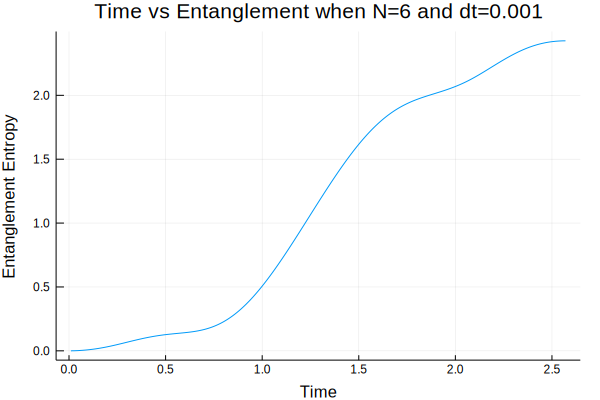

In [25]:
plot(steps1,entropies[1:fnl1],title="Time vs Entanglement when N=6 and dt=0.001",xlabel="Time",ylabel="Entanglement Entropy",labels="")

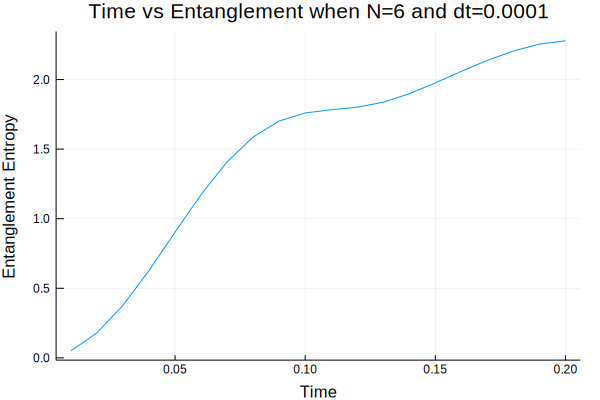

In [26]:
plot(steps2,entropies2[1:fnl2],title="Time vs Entanglement when N=6 and dt=0.0001",xlabel="Time",ylabel="Entanglement Entropy",labels="")

Again, the error in the divison mentioned above may have caused the above plot to momentarily go to zero around 0.029, but that is only an affect on the plot, and is not representative of the calculated entropies which evolve smoothly with time.

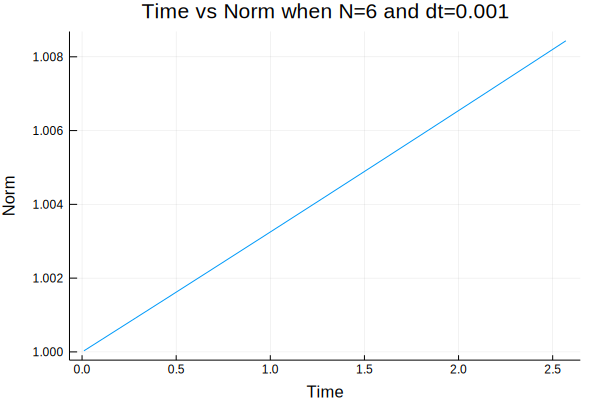

In [27]:
plot(steps1,norms[1:fnl1],title="Time vs Norm when N=6 and dt=0.001",xlabel="Time",ylabel="Norm",labels="")

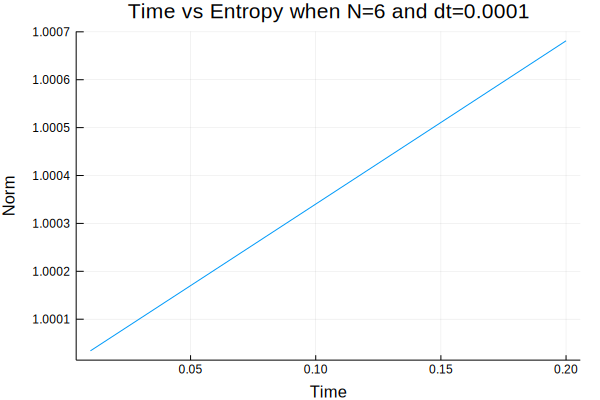

In [28]:
plot(steps2,norms2[1:fnl2],title="Time vs Entropy when N=6 and dt=0.0001",xlabel="Time",ylabel="Norm",labels="")

## Discussion and Conclusion:

The plots for N=6 show the entanglement increasing up to around 2.5, which is close to the expected value of 3. However, the decrease in timestep appears to be affecting the time the system takes to achieve maximum entropy, which should not be occurring. The increase in entanglement should also be linear with time, but is  not due to the loss of normalization shown in the plots of Norm vs time. It is clear from looking at the plots that the linearity increases as the timestep decreases and the norm is better preserved. The code to plot the entanglement vs time of N=20 spins until the system become maximally entangled is included below, but it was not run due to time constraints.

## Testing the code for N=20:

To make sure the code runs for N=20, first do a test run of 100 timesteps:

In [19]:
N = 20 # Number of spins

H = buildH(pi/4) # Building the Hamiltonian

# Initialize Psi for N random spins

Psi_temp = randn(2,N) + im*randn(2,N)
Psi = Psi_temp[:,1]

for i in 2:N
    Psi = kron(Psi,Psi_temp[:,i])
end

# Normalize Psi
Psi = Psi/sqrt(abs(Psi'*Psi))

# Compute how long the functions take to run:

@time multiplyHPsi(Psi,H)
@time compute_entropyNHalf(Psi)
;

  0.822140 seconds (331 allocations: 1.258 GiB, 27.44% gc time)
  0.443596 seconds (33 allocations: 64.814 MiB, 4.76% gc time)


In [21]:
dt = 0.001

Max = floor(Int64,T/dt)

entropies3 = zeros(100,1)
norms3 = zeros(100,1)

for i = 1:100
    
    if mod(i/Max*points,1) == 0
        display(i/Max*points)
    end

    S1 = compute_entropyNHalf(Psi)

    entropies3[i] = S1
    norms3[i] = norm(Psi)
   
    if mod(i/Max*points,1) == 0
        display(i/Max*points)
    end
    
    Psi = psiNew(Psi,H,dt)
    
end

1.0

1.0

In [22]:
print("The norm of Psi is: ", norm(Psi))

The norm of Psi is: 1.001750157744666

So the norm is mostly preserved during the evolution

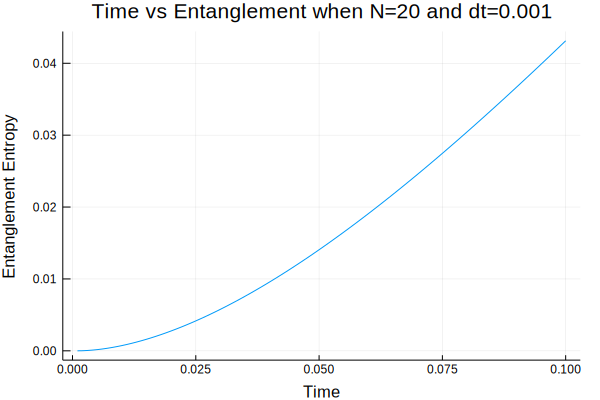

In [23]:
steps3 = zeros(100,1)

for i in 1:100
    steps3[i] = dt*i
end

plot(steps3,entropies3[1:100],title="Time vs Entanglement when N=20 and dt=0.001",xlabel="Time",ylabel="Entanglement Entropy",labels="")

So it is clear that the code is functional when N=20.

## Running the Code for N=20

Now that we know the code works, it can be run for N = 20:

First initialize the $\bra{\Psi(0)}$, then find the maximum dt that preserves the norm until time T, then run until the entropy converges.

In [ ]:
N = 6 # Number of spins

H = buildH(pi/4) # Building the Hamiltonian

# Initialize Psi for N random spins

Psi_temp = randn(2,N) + im*randn(2,N)
Psi = Psi_temp[:,1]

for i in 2:N
    Psi = kron(Psi,Psi_temp[:,i])
end

# Normalize Psi
Psi = Psi/sqrt(abs(Psi'*Psi))

# Compute how long the functions take to run:

@time multiplyHPsi(Psi,H)
@time compute_entropyNHalf(Psi)
;


In [ ]:
T = 10.0 # Time to evolve
dt = 10.0 # Timestep

epsilon = 10^-2

Psi_temp = 0

while norm(Psi_temp) < (1.0-epsilon) || norm(Psi_temp) > (1.0+epsilon)
    
    Psi_temp = Psi # Make sure Psi_temp is beginning normalized
    
    dt = dt/10.0 # Next timestep
    
    for i = 1:floor(Int64,T/dt)          # Evolve Psi_temp
        Psi_temp = psiNew(Psi_temp,H,dt)
    end
    
    print("Timestep size: ",dt, ", Norm:", norm(Psi_temp), "\n") # Print the stepsize and the norm
    
end

In [ ]:
Max = floor(Int64,T/dt) Maximum number of timesteps

points = 1000 # Number of points on the plots

entropies = zeros(points,1) # Initialize vectors to contain the entropies and the norms
norms = zeros(points,1)
i = 1

S1 = compute_entropyNHalf(Psi) # Compute the Entropy at the first time step and increment the step number
entropies[i] = S1
norms[i] = norm(Psi)
i = i + 1

Psi = psiNew(Psi,H,dt) # Evolve Psi

S2 = compute_entropyNHalf(Psi) # Compute the Entropy at the second time step and increment the step number
i = i + 1

Psi = psiNew(Psi,H,dt) # Evolve Psi

while abs(S2-S1) > dt^2 # Continue to evolve Psi until the entropy levels off
    
    if mod(i/Max*points,1) == 0 # display the i/Max*points so it's clear how long the code has been running
        display(i/Max*points)
    end
    
    S2 = S1
    
    S1 = compute_entropyNHalf(Psi) # compute entropy
    
    if mod(i/Max*points,1) == 0 # If the timestep is one of the plotpoints, save the entropy and compute and save the norm
        entropies[floor(Int64,i/Max*points)] = S1
        norms[floor(Int64,i/Max*points)] = norm(Psi)
    end
    
    i = i + 1
    
    if mod(i/Max*points,1) == 0 # display the i/Max*points so it's clear how long the code has been running
        display(i/Max*points)
    end
    
    if i/Max*points > points # If the number of timesteps exceeds the alloted number, exit the loop
        S1 = Inf
        display("Not enough steps")
    end
    
    Psi = psiNew(Psi,H,dt) # compute Psi att the next timestep
    
end

fnl1 = floor(Int64,i/Max*points) # the length of the grid for the plot

## Works Cited:

The course notes: https://github.com/eschnett/2018-computational-physics-course/tree/master/exact-diagonalization-module